In [1]:
from astropy.table import Table
import pylab as plt
import numpy as np
import scipy.stats as stats
from scipy.interpolate import UnivariateSpline
import sklearn.cluster as cluster

In [2]:
def FitsRead(time):
    if time < 10:
        time = '0{0}'.format(time)
    try:
        fileName = 'coords.starsandgas.chemrun733DiffFB10T1.0.00{0}0.fits'.format(time)
        read = Table.read(fileName,1)
        stars = (read['P']=='s')
        cat = read[stars]
    except:
        try:
            fileName = 'coords.chem733DiffFB10T1.0.00{0}0.fits'.format(time)
            cat = Table.read(fileName,1)
        except:
            raise ValueError('No file')
    return cat

In [3]:
txyz = Table.read('txyzform.fits',1)

In [4]:
rho = np.sqrt(txyz['XFORM']**2+txyz['YFORM']**2)
txyz.add_column(rho,name='RHO')

In [5]:
start = 0.15
dt = 0.001

In [7]:
for readTime in range(2,3):
    snapshot = FitsRead(readTime)
    r = np.sqrt(snapshot['X']**2+snapshot['Y']**2)
    theta = np.arctan2(snapshot['Y'],snapshot['X'])
    vth = -snapshot['VX']*np.sin(theta)+snapshot['VY']*np.cos(theta)
    bins = int(np.max(r)*10)
    medians,binEdges,binNumber = stats.binned_statistic(r,vth,'median',bins)
    edges = np.delete(binEdges,[len(binEdges)-1])
    w = np.isnan(medians)
    medians[w] = 0
    vDisk = UnivariateSpline(edges,medians,~w)
    while (round(start*10)==readTime or round(start*10)==0) and start==0.15:
        end = start+5*dt
        tRange = (txyz['TFORM']>start,txyz['TFORM']<end)
        inRange = np.array(np.zeros(len(tRange[0])),dtype=bool)
        for i in range(0,len(inRange)):
            if tRange[0][i] and tRange[1][i]:
                inRange[i] = True
        newStars = txyz[inRange]
        vcirc = vDisk(newStars['RHO'])
        dtime = newStars['TFORM']-start
        lindist = vcirc*dtime
        nrot = lindist/(2*np.pi*newStars['RHO'])
        nrotints = []
        for i in nrot:
            nrotints.append(int(i))
        nrotints = np.array(nrotints)
        rotangle = nrot-nrotints
        rotanglerad = 2*np.pi*rotangle
        xrot = newStars['XFORM']*np.cos(-rotanglerad)-newStars['YFORM']*np.sin(-rotanglerad)
        yrot = newStars['XFORM']*np.sin(-rotanglerad)+newStars['YFORM']*np.cos(-rotanglerad)
        #im, xedges, yedges  = np.histogram2d (xrot,yrot,(100,100),range=[[-3,3],[-3,3]])
        #extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
        #fig = plt.figure(figsize=(10,10))
        #plt.imshow(np.log(im),extent=extent)
        #plt.title("{0} million years".format(int(start*1000)))
        #fig.savefig("{0}.png".format(int(start*1000)))
        start = round(start+dt,3)

C:\Users\betha\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [8]:
for readTime in range(2,3):
    #Read fits for nearest time
    snapshot = FitsRead(readTime)
    
    #Find r, theta, and Vtheta
    r = np.sqrt(snapshot['X']**2+snapshot['Y']**2)
    theta = np.arctan2(snapshot['Y'],snapshot['X'])
    vth = -snapshot['VX']*np.sin(theta)+snapshot['VY']*np.cos(theta)
    
    #Find Vtheta as a function of distance from axis
    bins = int(np.max(r)*10)
    medians,binEdges,binNumber = stats.binned_statistic(r,vth,'median',bins)
    edges = np.delete(binEdges,[len(binEdges)-1])
    w = np.isnan(medians)
    medians[w] = 0
    vDisk = UnivariateSpline(edges,medians,~w)
    
    #Loop through time ranges
    while (round(start*10)==readTime or round(start*10)==0) and start<0.17:
        end = start+5*dt
        
        #Find stars born in the time range
        tRange = (txyz['TFORM']>start,txyz['TFORM']<end)
        inRange = np.array(np.zeros(len(tRange[0])),dtype=bool)
        for i in range(0,len(inRange)):
            if tRange[0][i] and tRange[1][i]:
                inRange[i] = True
        newStars = txyz[inRange]
        
        #Move stars back in time
        vcirc = vDisk(newStars['RHO'])
        dtime = newStars['TFORM']-start
        lindist = vcirc*dtime
        nrot = lindist/(2*np.pi*newStars['RHO'])
        nrotints = []
        for i in nrot:
            nrotints.append(int(i))
        nrotints = np.array(nrotints)
        rotangle = nrot-nrotints
        rotanglerad = 2*np.pi*rotangle
        xrot = newStars['XFORM']*np.cos(-rotanglerad)-newStars['YFORM']*np.sin(-rotanglerad)
        yrot = newStars['XFORM']*np.sin(-rotanglerad)+newStars['YFORM']*np.cos(-rotanglerad)
        
        #Find clusters
        X = np.zeros((len(xrot),2))
        for i in range(0,len(xrot)):
            X[i][0] = xrot[i]
            X[i][1] = yrot[i]
        db = cluster.DBSCAN(eps=0.1, min_samples=100).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_
        
        #Plot clusters
        fig = plt.figure(figsize=(10,10))
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=14)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plt.title("{0} million years".format(int(start*1000)))
        start = round(start+dt,3)

C:\Users\betha\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


C:\Users\betha\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


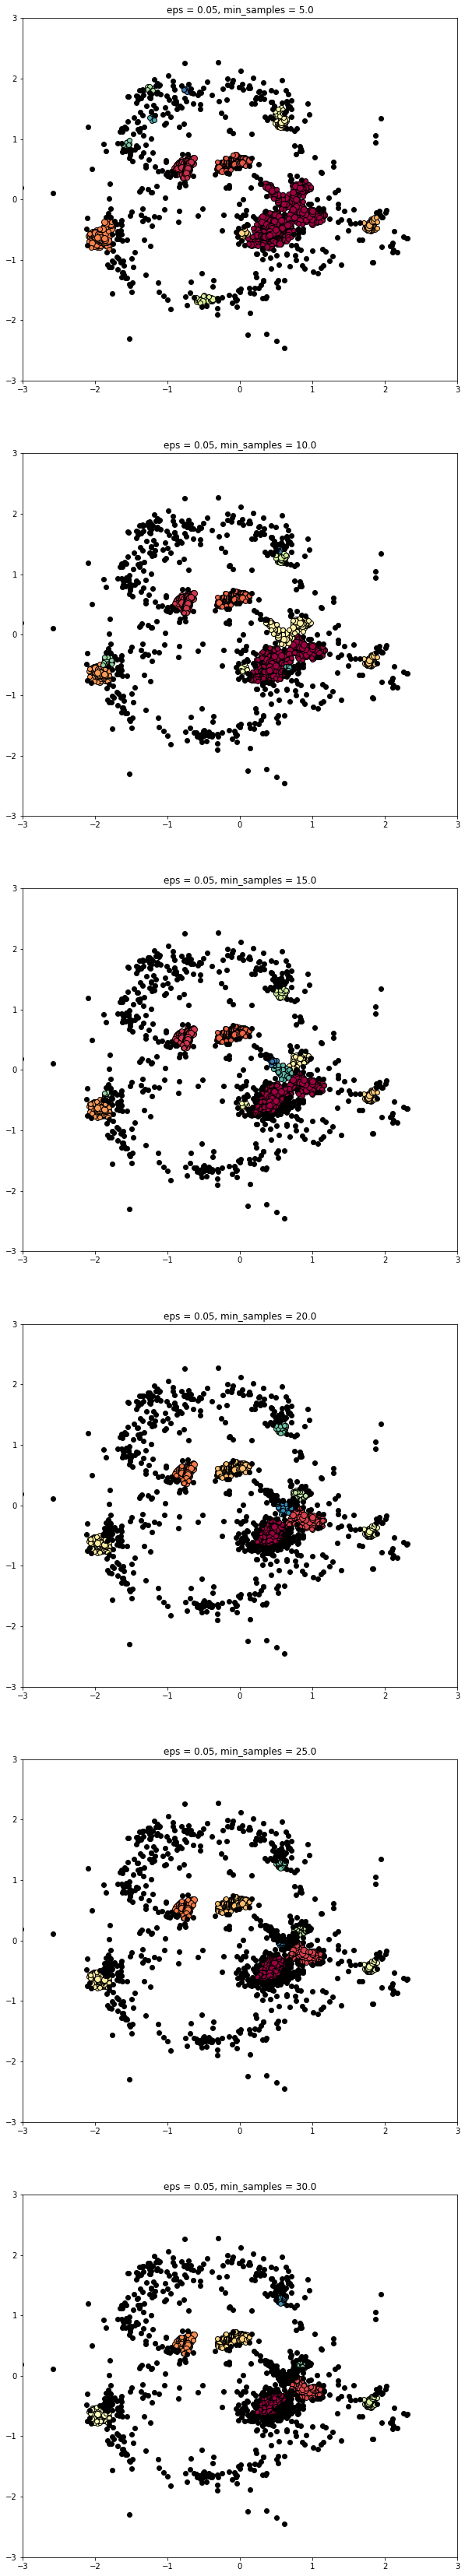

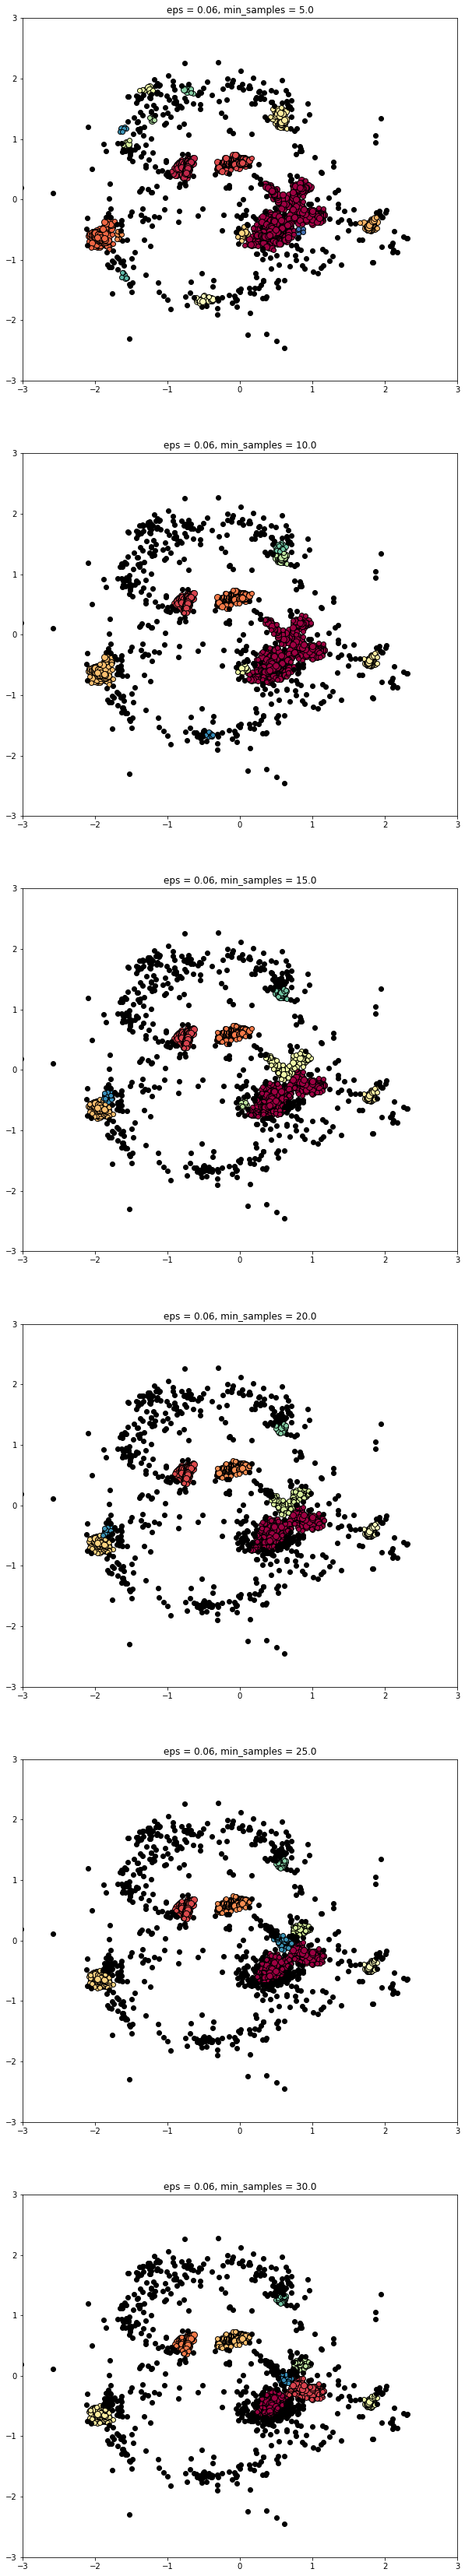

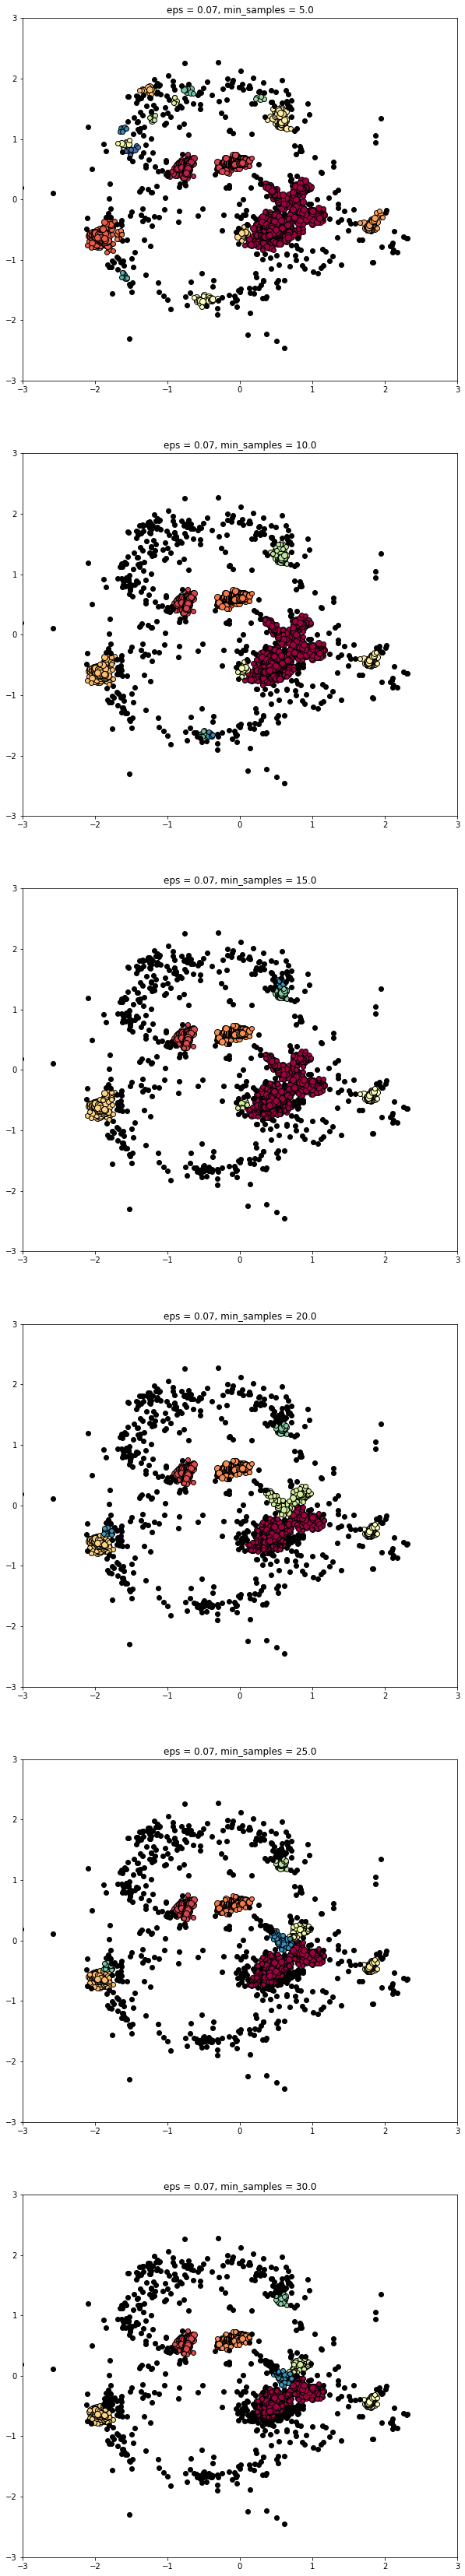

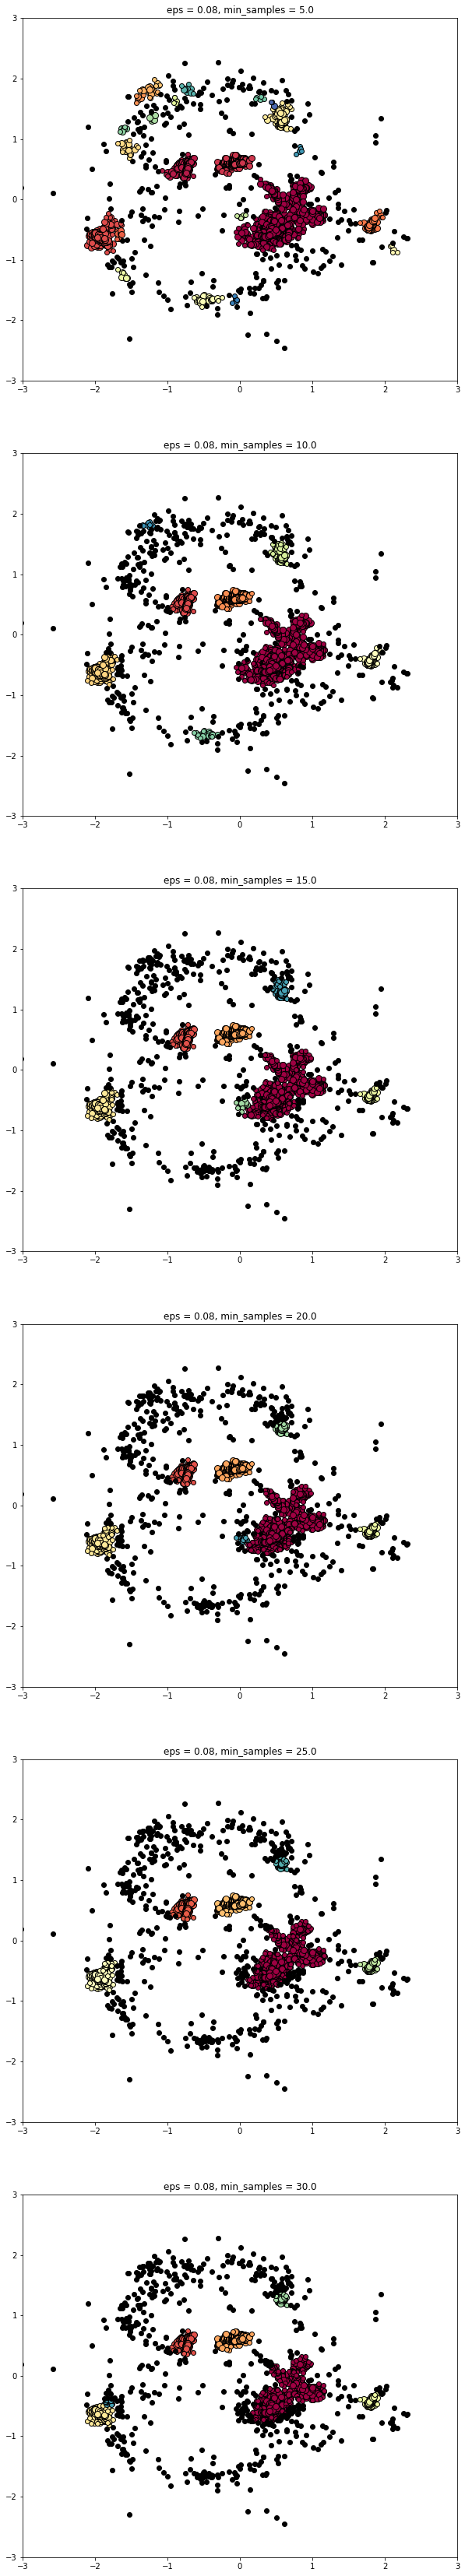

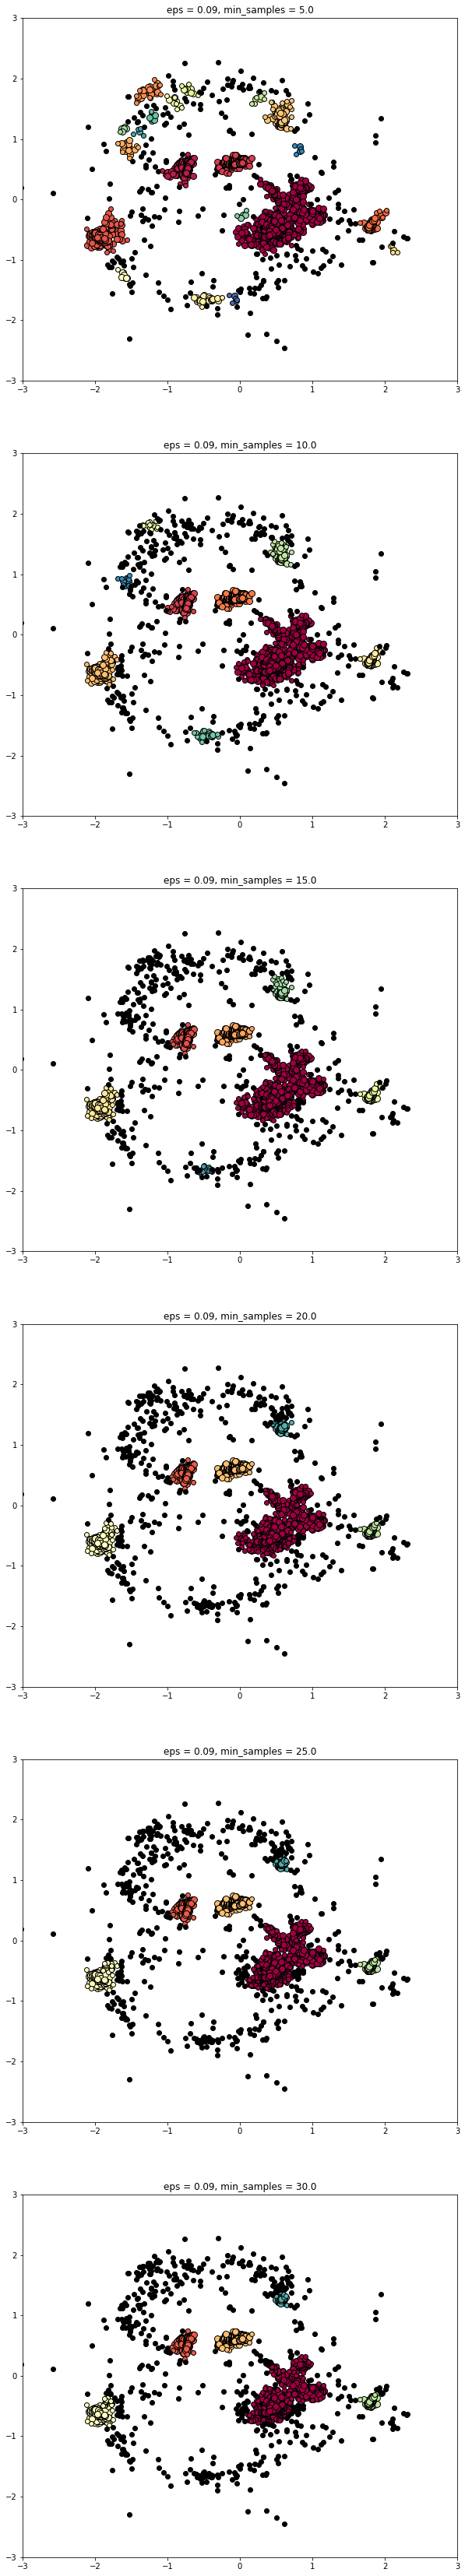

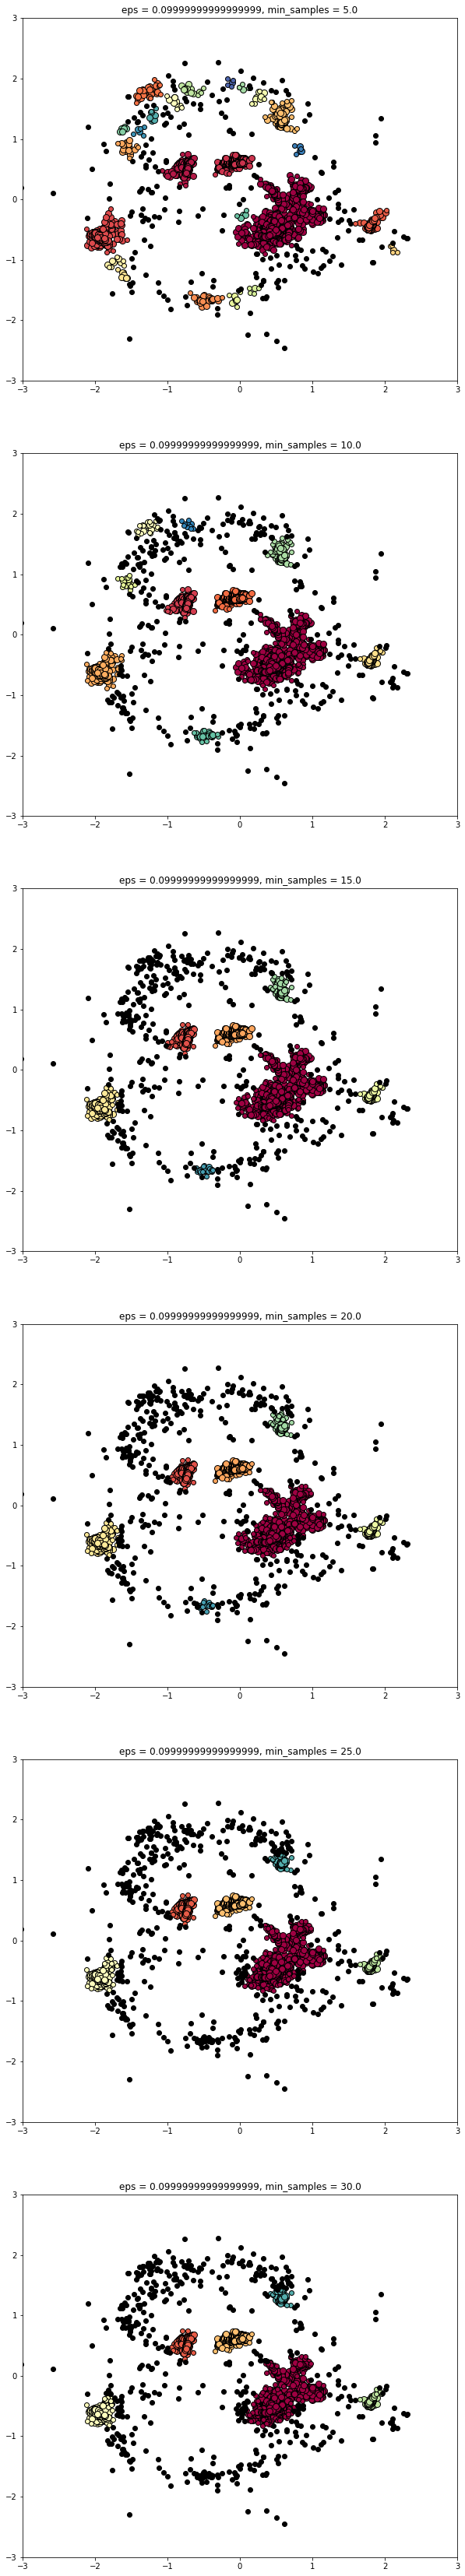

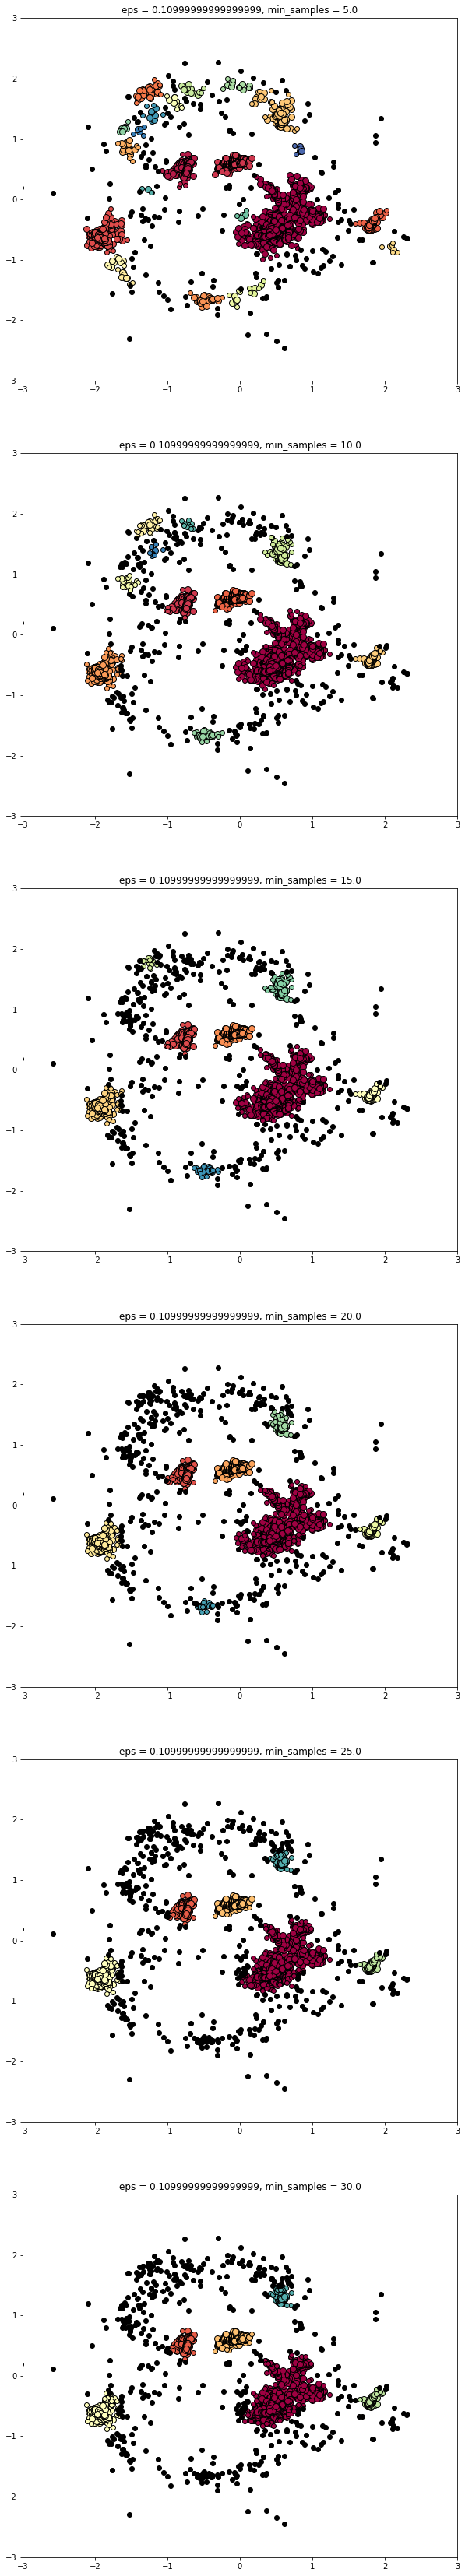

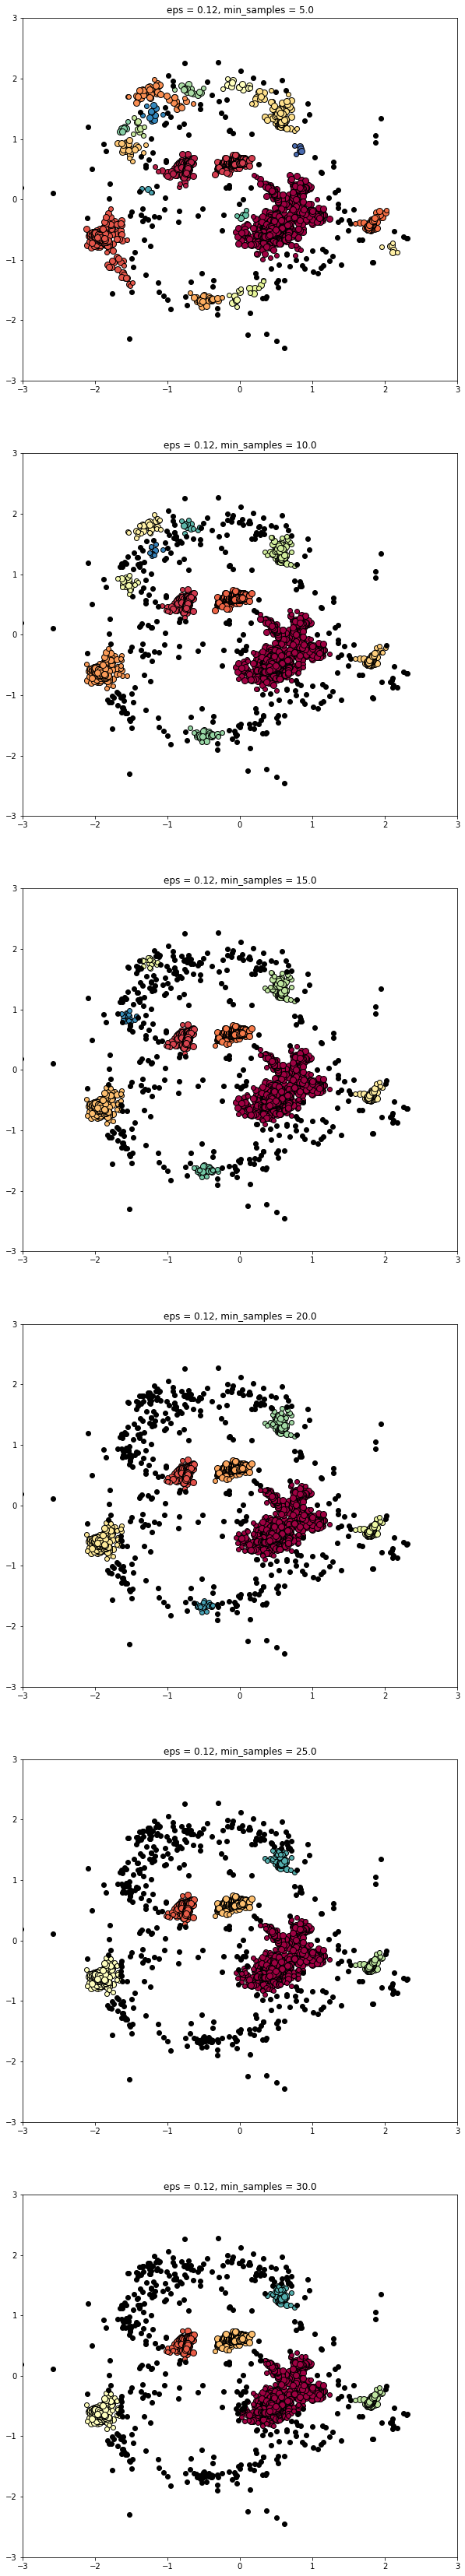

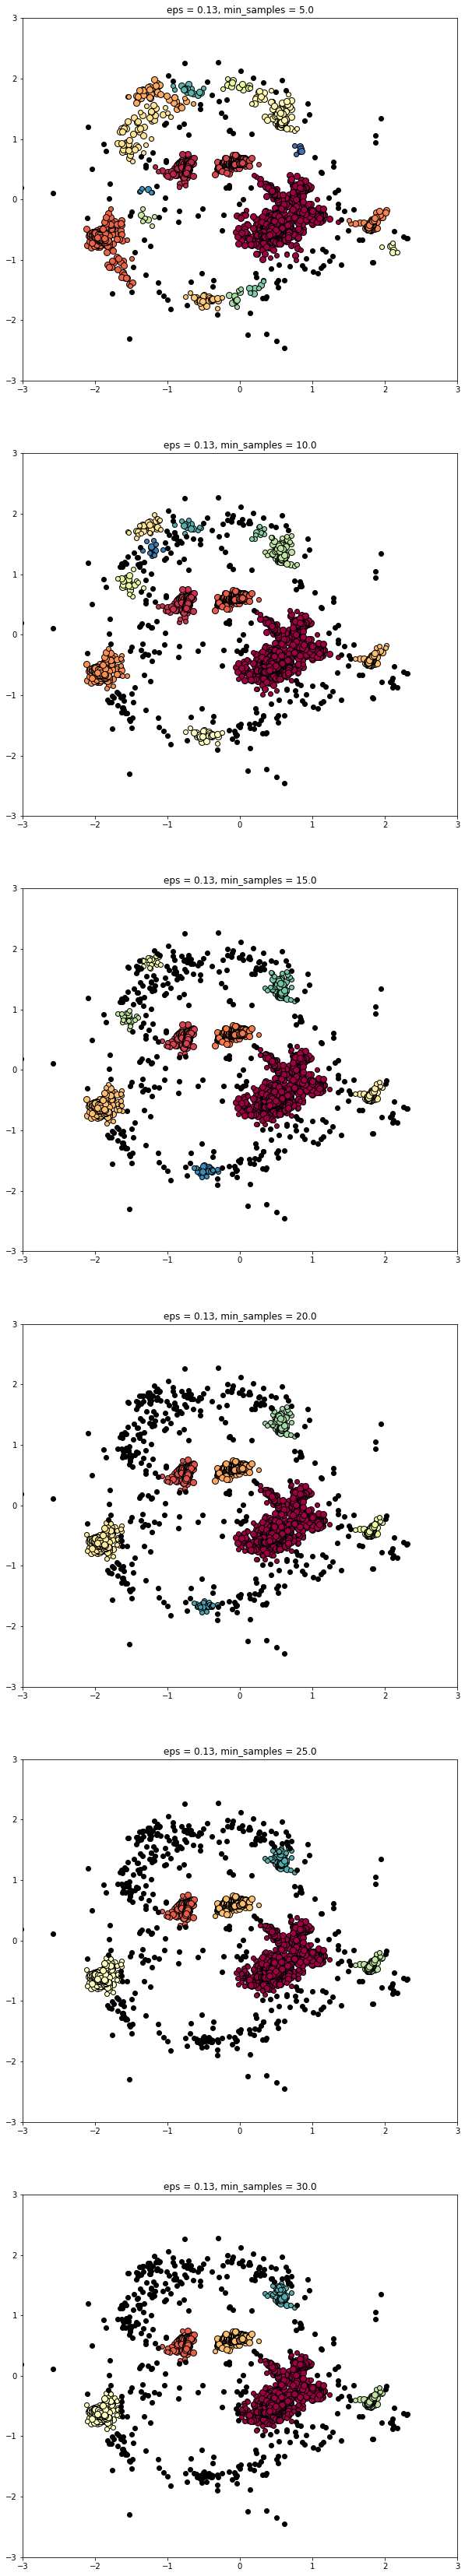

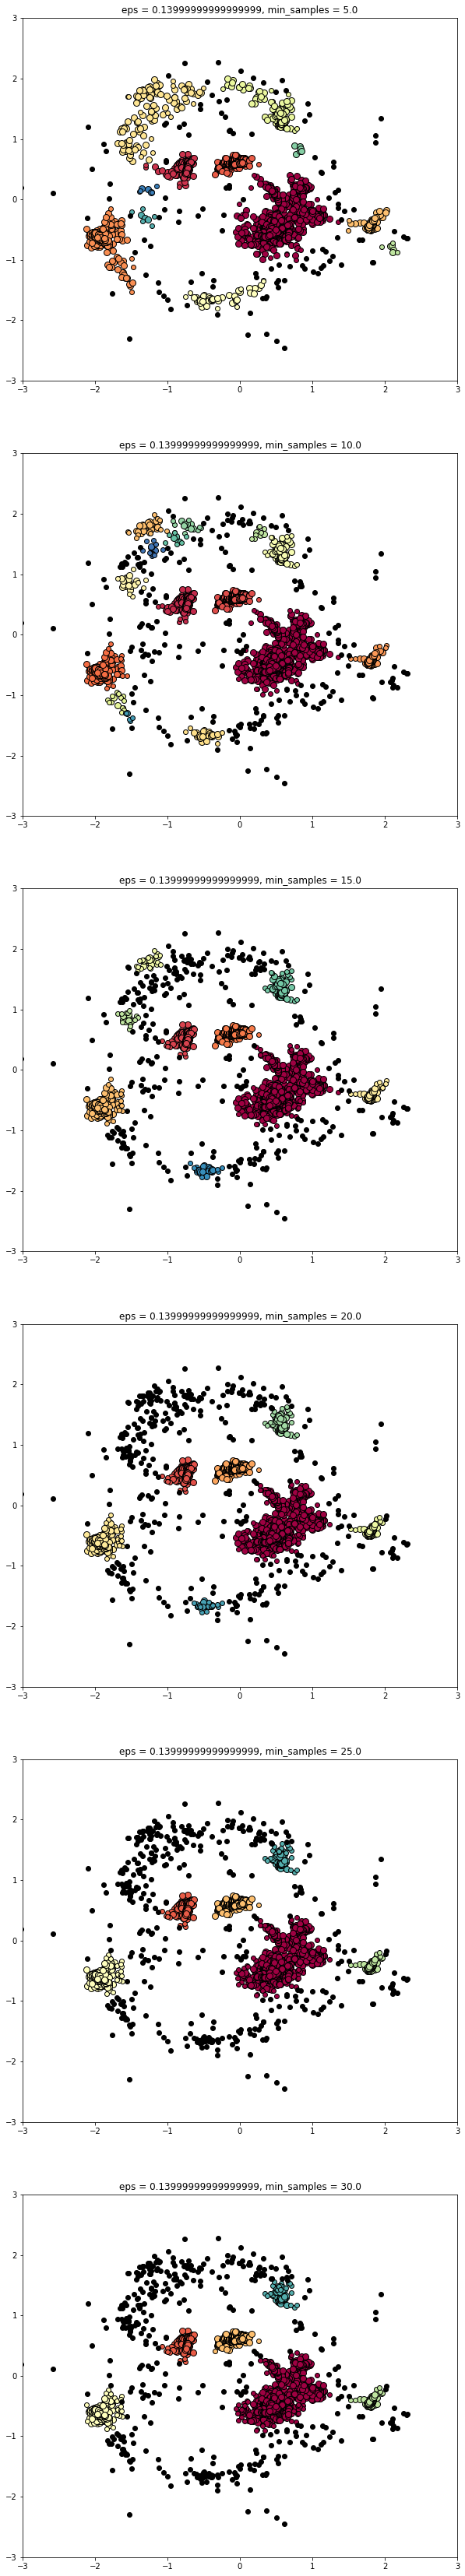

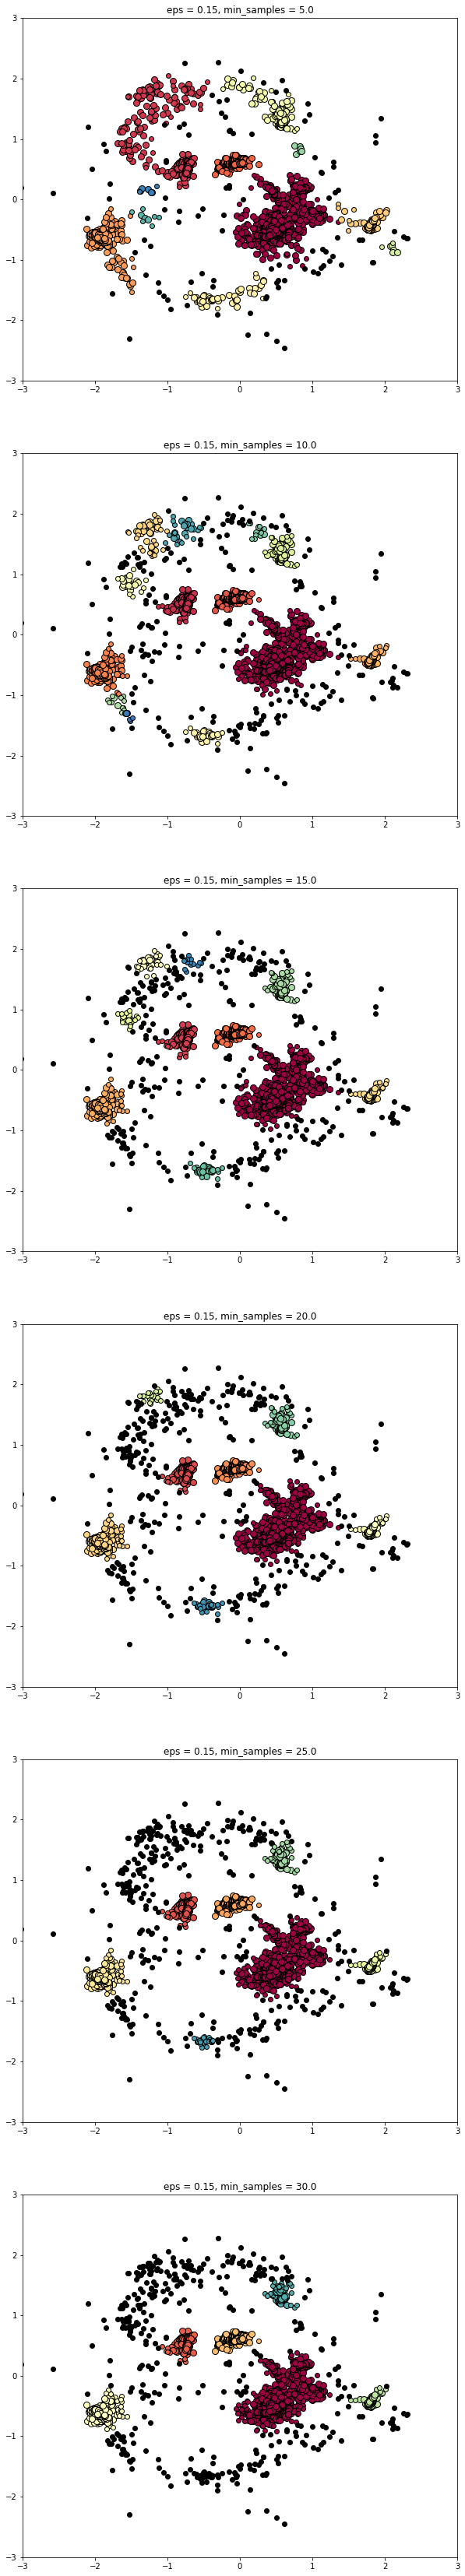

In [15]:
#Read fits for nearest time
snapshot = FitsRead(2)
    
#Find r, theta, and Vtheta
r = np.sqrt(snapshot['X']**2+snapshot['Y']**2)
theta = np.arctan2(snapshot['Y'],snapshot['X'])
vth = -snapshot['VX']*np.sin(theta)+snapshot['VY']*np.cos(theta)
    
#Find Vtheta as a function of distance from axis
bins = int(np.max(r)*10)
medians,binEdges,binNumber = stats.binned_statistic(r,vth,'median',bins)
edges = np.delete(binEdges,[len(binEdges)-1])
w = np.isnan(medians)
medians[w] = 0
vDisk = UnivariateSpline(edges,medians,~w)
    
start = 0.2
end = 0.205

#Find stars born in the time range
tRange = (txyz['TFORM']>start,txyz['TFORM']<end)
inRange = np.array(np.zeros(len(tRange[0])),dtype=bool)
for i in range(0,len(inRange)):
    if tRange[0][i] and tRange[1][i]:
        inRange[i] = True
newStars = txyz[inRange]

#Move stars back in time
vcirc = vDisk(newStars['RHO'])
dtime = newStars['TFORM']-start
lindist = vcirc*dtime
nrot = lindist/(2*np.pi*newStars['RHO'])
nrotints = []
for i in nrot:
    nrotints.append(int(i))
nrotints = np.array(nrotints)
rotangle = nrot-nrotints
rotanglerad = 2*np.pi*rotangle
xrot = newStars['XFORM']*np.cos(-rotanglerad)-newStars['YFORM']*np.sin(-rotanglerad)
yrot = newStars['XFORM']*np.sin(-rotanglerad)+newStars['YFORM']*np.cos(-rotanglerad)

epsList = np.linspace(0.05,0.15,11)
samplesList = np.linspace(5,30,6)
#Find clusters
X = np.zeros((len(xrot),2))
for i in range(0,len(xrot)):
    X[i][0] = xrot[i]
    X[i][1] = yrot[i]
for e in epsList:
    plt.figure(figsize=(10,60))
    for s in samplesList:
        db = cluster.DBSCAN(eps=e, min_samples=s).fit(X)
        core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        #Plot clusters
        unique_labels = set(labels)
        colors = [plt.cm.Spectral(each)
                  for each in np.linspace(0, 1, len(unique_labels))]
        plt.subplot(6,1,s/5)
        for k, col in zip(unique_labels, colors):
            if k == -1:
                # Black used for noise.
                col = [0, 0, 0, 1]

            class_member_mask = (labels == k)

            xy = X[class_member_mask & core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=8)

            xy = X[class_member_mask & ~core_samples_mask]
            plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
                     markeredgecolor='k', markersize=6)

        plt.xlim(-3,3)
        plt.ylim(-3,3)
        plt.title("eps = {0}, min_samples = {1}".format(e,s))

C:\Users\betha\Anaconda3\lib\site-packages\scipy\stats\_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


Total new stars: 4151

Clump 0:
Stars in clump: 1330
Mean X: 0.6280371877393895
Mean Y: -0.38334353326924103
Mean Rotation Velocity: 102.08112075908993

Clump 1:
Stars in clump: 587
Mean X: -0.7515592612334249
Mean Y: 0.5530587496443818
Mean Rotation Velocity: 110.83395161195081

Clump 2:
Stars in clump: 591
Mean X: -0.10146580341586409
Mean Y: 0.6048812180025093
Mean Rotation Velocity: 107.28492533278008

Clump 3:
Stars in clump: 416
Mean X: -1.94113238074807
Mean Y: -0.641877228013289
Mean Rotation Velocity: 134.36513819281345

Clump 4:
Stars in clump: 317
Mean X: 1.7921888630704497
Mean Y: -0.4373214287671802
Mean Rotation Velocity: 146.4324714064175

Clump 5:
Stars in clump: 249
Mean X: 0.6827519808854289
Mean Y: 0.0889247325562629
Mean Rotation Velocity: 81.94059684921496

Clump 6:
Stars in clump: 56
Mean X: 0.5752720233985894
Mean Y: 1.26304909251877
Mean Rotation Velocity: 145.8832449146199

Clump 7:
Stars in clump: 27
Mean X: -1.8264533188429626
Mean Y: -0.42408815261499155
Mea

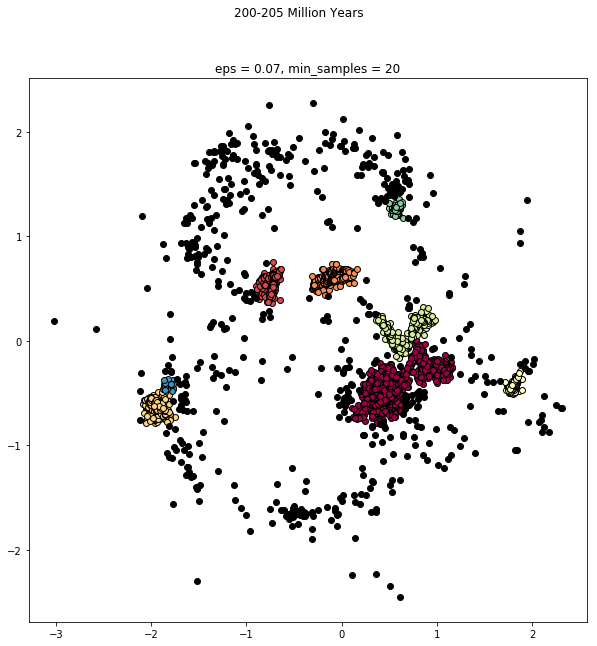

In [11]:
#Read fits for nearest time
snapshot = FitsRead(2)
    
#Find r, theta, and Vtheta
r = np.sqrt(snapshot['X']**2+snapshot['Y']**2)
theta = np.arctan2(snapshot['Y'],snapshot['X'])
vth = -snapshot['VX']*np.sin(theta)+snapshot['VY']*np.cos(theta)
    
#Find Vtheta as a function of distance from axis
bins = int(np.max(r)*10)
medians,binEdges,binNumber = stats.binned_statistic(r,vth,'median',bins)
edges = np.delete(binEdges,[len(binEdges)-1])
w = np.isnan(medians)
medians[w] = 0
vDisk = UnivariateSpline(edges,medians,~w)
    
start = 0.2
end = 0.205

#Find stars born in the time range
tRange = (txyz['TFORM']>start,txyz['TFORM']<end)
inRange = np.array(np.zeros(len(tRange[0])),dtype=bool)
for i in range(0,len(inRange)):
    if tRange[0][i] and tRange[1][i]:
        inRange[i] = True
newStars = txyz[inRange]

#Move stars back in time
vcirc = vDisk(newStars['RHO'])
newStars.add_column(Table.Column(vcirc),name='VCIRC')
dtime = newStars['TFORM']-start
lindist = vcirc*dtime
nrot = lindist/(2*np.pi*newStars['RHO'])
nrotints = []
for i in nrot:
    nrotints.append(int(i))
nrotints = np.array(nrotints)
rotangle = nrot-nrotints
rotanglerad = 2*np.pi*rotangle
xrot = newStars['XFORM']*np.cos(-rotanglerad)-newStars['YFORM']*np.sin(-rotanglerad)
yrot = newStars['XFORM']*np.sin(-rotanglerad)+newStars['YFORM']*np.cos(-rotanglerad)
newStars.add_column(xrot,name='X')
newStars.add_column(yrot,name='Y')
print('Total new stars: {0}'.format(len(newStars)))
print()

#Find clusters
X = np.zeros((len(xrot),2))
for i in range(0,len(xrot)):
    X[i][0] = xrot[i]
    X[i][1] = yrot[i]
db = cluster.DBSCAN(eps=0.07, min_samples=20).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

#Cluster information and plot
unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
plt.figure(figsize=(10,10))
for k, col in zip(unique_labels, colors):
    class_member_mask = (labels == k)
    inClump = newStars[class_member_mask]

    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
    else:
        print("Clump {0}:".format(k))
        print("Stars in clump: {0}".format(len(inClump)))
        print("Mean X: {0}".format(np.mean(inClump['X'])))
        print("Mean Y: {0}".format(np.mean(inClump['Y'])))
        print("Mean Rotation Velocity: {0}".format(np.mean(inClump['VCIRC'])))
        print()
    
    plt.plot(inClump['X'], inClump['Y'], 'o', markerfacecolor=tuple(col), markeredgecolor='k', markersize=6)
    plt.suptitle('200-205 Million Years')
    plt.title('eps = 0.07, min_samples = 20')